# PGP AI - Natural Language Processing

## Project 1: Topic Analysis of Review Data

> ***Author***
>
> ***Saikat Narayan Bhattacharjya***
>
> ***Email: <snbhattacharjya@gmail.com>***

#### DESCRIPTION

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon and the topics that customers are talking about. You will perform topic modeling on specific parts of speech. You’ll finally interpret the emerging topics.

#### Problem Statement: 

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

**Domain:** Amazon reviews for a leading phone brand

#### Analysis to be done: 
POS tagging, topic modeling using LDA, and topic interpretation

**Dataset:** ‘K8 Reviews v0.2.csv’

**Sentiment:** The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)

**Reviews:** The main text of the review

#### Steps to perform:

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.

Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. Finally, give business-friendly names to the topics and make a table for business.

#### Tasks: 

1. Read the .csv file using Pandas. Take a look at the top few records.

2. Normalize casings for the review text and extract the text into a list for easier manipulation.

3. Tokenize the reviews using NLTKs word_tokenize function.

4. Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

5. For the topic model, we should  want to include only nouns.

  - Find out all the POS tags that correspond to nouns.

  - Limit the data to only terms with these tags.

6. Lemmatize. 

  - Different forms of the terms need to be treated as one.

  - No need to provide POS tag to lemmatizer for now.

7. Remove stopwords and punctuation (if there are any). 

8. Create a topic model using LDA on the cleaned up data with 12 topics.

  - Print out the top terms for each topic.

  - What is the coherence of the model with the c_v metric?

9. Analyze the topics through the business lens.

  - Determine which of the topics can be combined.

10. Create topic model using LDA with what you think is the optimal number of topics

  - What is the coherence of the model?

11. The business should  be able to interpret the topics.

  - Name each of the identified topics.

  - Create a table with the topic name and the top 10 terms in each to present to the  business.

#### Environment Setup

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import gensim
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Read the data

In [2]:
data = pd.read_csv('K8 Reviews v0.2.csv')

#### Understanding the data

In [3]:
data.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


#### 2. Normalizing the casing to lower

In [5]:
data['review_cleaned'] = data['review'].apply(lambda review: review.lower())

In [6]:
data.head()

,sentiment,review,review_cleaned
0,1,Good but need updates and improvements,good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr...","worst mobile i have bought ever, battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...,when i will get my 10% cash back.... its alrea...
3,1,Good,good
4,0,The worst phone everThey have changed the last...,the worst phone everthey have changed the last...


#### 3. Tokenize the reviews using NLTKs word_tokenize function.

In [7]:
reviews = data['review_cleaned']
reviews = [nltk.word_tokenize(review) for review in reviews]

In [8]:
len(reviews)

14675

In [9]:
pprint(reviews[:5], compact=True)

[['good', 'but', 'need', 'updates', 'and', 'improvements'],
 ['worst', 'mobile', 'i', 'have', 'bought', 'ever', ',', 'battery', 'is',
  'draining', 'like', 'hell', ',', 'backup', 'is', 'only', '6', 'to', '7',
  'hours', 'with', 'internet', 'uses', ',', 'even', 'if', 'i', 'put', 'mobile',
  'idle', 'its', 'getting', 'discharged.this', 'is', 'biggest', 'lie', 'from',
  'amazon', '&', 'lenove', 'which', 'is', 'not', 'at', 'all', 'expected', ',',
  'they', 'are', 'making', 'full', 'by', 'saying', 'that', 'battery', 'is',
  '4000mah', '&', 'booster', 'charger', 'is', 'fake', ',', 'it', 'takes', 'at',
  'least', '4', 'to', '5', 'hours', 'to', 'be', 'fully', 'charged.do', "n't",
  'know', 'how', 'lenovo', 'will', 'survive', 'by', 'making', 'full', 'of',
  'us.please', 'don', ';', 't', 'go', 'for', 'this', 'else', 'you', 'will',
  'regret', 'like', 'me', '.'],
 ['when', 'i', 'will', 'get', 'my', '10', '%', 'cash', 'back', '...', '.',
  'its', 'already', '15', 'january..'],
 ['good'],
 ['the', 

#### 4. Perform parts-of-speech tagging on each document using the NLTK POS tagger

In [10]:
%%time
review_pos_tags = [nltk.pos_tag(doc) for doc in reviews]
pprint(review_pos_tags[:5], compact=True)

[[('good', 'JJ'), ('but', 'CC'), ('need', 'VBP'), ('updates', 'NNS'),
  ('and', 'CC'), ('improvements', 'NNS')],
 [('worst', 'JJS'), ('mobile', 'NN'), ('i', 'NN'), ('have', 'VBP'),
  ('bought', 'VBN'), ('ever', 'RB'), (',', ','), ('battery', 'NN'),
  ('is', 'VBZ'), ('draining', 'VBG'), ('like', 'IN'), ('hell', 'NN'),
  (',', ','), ('backup', 'NN'), ('is', 'VBZ'), ('only', 'RB'), ('6', 'CD'),
  ('to', 'TO'), ('7', 'CD'), ('hours', 'NNS'), ('with', 'IN'),
  ('internet', 'JJ'), ('uses', 'NNS'), (',', ','), ('even', 'RB'), ('if', 'IN'),
  ('i', 'JJ'), ('put', 'VBP'), ('mobile', 'JJ'), ('idle', 'NN'),
  ('its', 'PRP$'), ('getting', 'VBG'), ('discharged.this', 'NN'), ('is', 'VBZ'),
  ('biggest', 'JJS'), ('lie', 'NN'), ('from', 'IN'), ('amazon', 'NN'),
  ('&', 'CC'), ('lenove', 'NN'), ('which', 'WDT'), ('is', 'VBZ'), ('not', 'RB'),
  ('at', 'IN'), ('all', 'DT'), ('expected', 'VBN'), (',', ','), ('they', 'PRP'),
  ('are', 'VBP'), ('making', 'VBG'), ('full', 'JJ'), ('by', 'IN'),
  ('saying', 'V

#### 5. Including only nouns for building the Topic Model

In [11]:
review_nouns = [[token for token, pos in doc if pos.startswith('NN')] for doc in review_pos_tags]
pprint(review_nouns[:5], compact=True)

[['updates', 'improvements'],
 ['mobile', 'i', 'battery', 'hell', 'backup', 'hours', 'uses', 'idle',
  'discharged.this', 'lie', 'amazon', 'lenove', 'battery', 'charger', 'hours',
  'don'],
 ['i', '%', 'cash', 'january..'], [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]


#### 6. Lemmatize

In [12]:
%%time
review_lemmatized = [[nltk.stem.WordNetLemmatizer().lemmatize(token) for token in doc] for doc in review_nouns]
pprint(review_lemmatized[:5],compact=True)

[['update', 'improvement'],
 ['mobile', 'i', 'battery', 'hell', 'backup', 'hour', 'us', 'idle',
  'discharged.this', 'lie', 'amazon', 'lenove', 'battery', 'charger', 'hour',
  'don'],
 ['i', '%', 'cash', 'january..'], [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]
Wall time: 3.13 s


#### 7. Remove stopwords and punctuation (if there are any).

In [13]:
%%time
review_no_sw = [[token for token in doc if token not in nltk.corpus.stopwords.words('english') 
                 and token.isalpha()] 
                for doc in review_lemmatized]
pprint(review_no_sw[:5], compact=True)

[['update', 'improvement'],
 ['mobile', 'battery', 'hell', 'backup', 'hour', 'us', 'idle', 'lie', 'amazon',
  'lenove', 'battery', 'charger', 'hour'],
 ['cash'], [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]
Wall time: 25.9 s


#### 8. Create a topic model using LDA on the cleaned up data with 12 topics.

In [14]:
# Build a Dictionary - association word to numeric id
dictionary = gensim.corpora.Dictionary(review_no_sw)
# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in review_no_sw]

In [15]:
NUM_TOPICS = 12
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=1)

#### 8.1 Print out the top terms for each topic.

In [16]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    pprint("Topic #{}: {}".format(idx, lda_model.print_topic(idx, 10)), compact=True)

LDA Model:
('Topic #0: 0.070*"battery" + 0.043*"phone" + 0.042*"screen" + 0.037*"day" + '
 '0.023*"camera" + 0.019*"ram" + 0.016*"note" + 0.015*"hr" + 0.014*"time" + '
 '0.014*"app"')
('Topic #1: 0.371*"mobile" + 0.046*"glass" + 0.040*"buy" + 0.032*"phone" + '
 '0.025*"gorilla" + 0.017*"purchase" + 0.016*"star" + 0.013*"mi" + '
 '0.012*"jata" + 0.011*"rating"')
('Topic #2: 0.087*"issue" + 0.083*"phone" + 0.056*"network" + 0.025*"sim" + '
 '0.024*"note" + 0.024*"call" + 0.023*"time" + 0.023*"battery" + '
 '0.017*"problem" + 0.015*"jio"')
('Topic #3: 0.210*"product" + 0.095*"phone" + 0.053*"service" + 0.042*"lenovo" '
 '+ 0.025*"amazon" + 0.018*"customer" + 0.017*"time" + 0.016*"please" + '
 '0.015*"center" + 0.015*"day"')
('Topic #4: 0.081*"battery" + 0.046*"device" + 0.039*"hour" + 0.028*"charging" '
 '+ 0.025*"drain" + 0.025*"camera" + 0.025*"day" + 0.024*"amazon" + '
 '0.023*"speaker" + 0.022*"problem"')
('Topic #5: 0.144*"camera" + 0.050*"phone" + 0.027*"mode" + 0.025*"hai" + '
 '0.

#### Visualising the topic model as per problem statement

In [17]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.062669 -0.085116       1        1  11.862483
0      0.096116  0.026158       2        1  11.853811
5      0.053151  0.190229       3        1  10.869544
3     -0.013538 -0.166455       4        1  10.680003
11     0.041287  0.002238       5        1   9.842621
8      0.082603  0.140830       6        1   9.113233
4      0.133813 -0.090946       7        1   8.402766
6      0.157541 -0.061287       8        1   7.171015
10    -0.082527 -0.065386       9        1   6.002136
9     -0.137876  0.105236      10        1   5.432816
7     -0.113252  0.065543      11        1   4.400358
1     -0.279987 -0.061043      12        1   4.369219, topic_info=        Term         Freq        Total Category  logprob  loglift
11    mobile  1666.000000  1666.000000  Default  30.0000  30.0000
47   product  2176.000000  2176.000000  Default  29.0000  29.0000
63     price   940.000000   940.000000  Default  28.0000  28.0000
4    battery  3159.000000  3159.000000  Default  27.0000  27.0000
15     phone  6989.000000  6989.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
55    camera    32.057770  3218.902832  Topic12  -4.6954  -1.4787
143     cost    15.872128    85.740356  Topic12  -5.3984   1.4438
47   product    19.431063  2176.538330  Topic12  -5.1961  -1.5880
48     range    16.938084   365.143921  Topic12  -5.3334   0.0599
85       day    16.587637   940.727966  Topic12  -5.3543  -0.9074

[741 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1328      5  0.955870     access
332       2  0.969151  accessory
332      10  0.024850  accessory
912       2  0.097246    account
912       7  0.875212    account
...     ...       ...        ...
26        9  0.047411       year
902       8  0.883449        yes
1024      3  0.965699  yesterday
1024      5  0.029264  yesterday
1770      3  0.963135       zoom

[1904 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 4, 12, 9, 5, 7, 11, 10, 8, 2])

#### 8.2 coherence of the model with the c_v metric

In [18]:
# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_no_sw, 
                                                   dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.49850343048731377


#### 9. Analyze the topics through the business lens - Determine which of the topics can be combined

Now since the problem at hand, demands identifying the different aspects of the budget smartphone launched in the market, it is imperative that the tokens (words in the customer reviews) with length less than 3 characters may be removed. That way topic model focuses on the variety of aspects like 'camera', 'battery'. Also removing tokens for length less than three would clean the dataset from low significant tokens.

In [19]:
#custom_stop_words = ['problem', 'issue']

review_no_custom_sw = [[token for token in doc if len(token) > 3] for doc in review_no_sw]

pprint(review_no_custom_sw[:5], compact=True)

[['update', 'improvement'],
 ['mobile', 'battery', 'hell', 'backup', 'hour', 'idle', 'amazon', 'lenove',
  'battery', 'charger', 'hour'],
 ['cash'], [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]


#### Building up the topic model after removing tokens of length < 3

In [20]:
%%time
NUM_TOPICS = 12
# Build a Dictionary - association word to numeric id
dictionary = gensim.corpora.Dictionary(review_no_custom_sw)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in review_no_custom_sw]

#Creating the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=1)

#Calculating the cohenrence score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_no_custom_sw, 
                                                   dictionary=dictionary, coherence='c_v')

#Collecting the score in tuple
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score after removing custom stop words: ', coherence_lda)

Coherence Score after removing custom stop words:  0.5031360323267438
Wall time: 12 s


***There is only a marginal change in the cv score, hence we need to search the parameter space for number of topics for the optimal cv score.***

#### 10. Create topic model using LDA with the optimal number of topics

#### Gensim Model for finding the optimal number of topics

In [21]:
%%time
NUM_TOPICS = range(3,21)
coherence_lda_scores = []
best_coherence_score = 0
best_lda_model = None

for topic in NUM_TOPICS:
    #Creating the LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=topic, id2word=dictionary, random_state=1)
    
    #Calculating the cohenrence score
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_no_custom_sw, 
                                                       dictionary=dictionary, coherence='c_v')
    
    #Collecting the score in tuple
    score = coherence_model_lda.get_coherence()
    coherence_lda_scores.append((topic, score))
    
    if(score > best_coherence_score):
        best_lda_model = lda_model
        best_coherence_score = score

pprint(coherence_lda_scores, compact=True)

[(3, 0.4808409861539009), (4, 0.47658927077528973), (5, 0.49770274426195626),
 (6, 0.5091871939495295), (7, 0.5101335633630214), (8, 0.5327501878460171),
 (9, 0.514572217631393), (10, 0.4954951459691387), (11, 0.49466269660317613),
 (12, 0.5031360323267438), (13, 0.47298989182999546), (14, 0.4734695313637629),
 (15, 0.4902114977648099), (16, 0.48648530584659017), (17, 0.48581874846503603),
 (18, 0.4643128110133583), (19, 0.47288850774759045), (20, 0.464743223947254)]
Wall time: 3min 10s


#### Visualising the coherence scores for the parameter number of topics for range 3 to 20

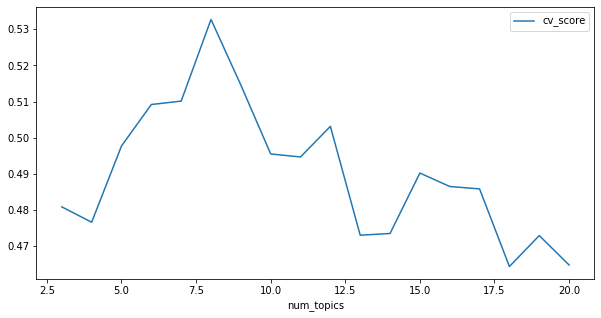

In [22]:
cv_df = pd.DataFrame(coherence_lda_scores, columns=['num_topics', 'cv_score'])
cv_df.plot(x='num_topics',figsize=(10,5))
plt.show()

#### 10.1 Coherence of the Optimal Model

In [23]:
best_num_topic, best_cv_score = int(cv_df.iloc[np.argmax(cv_df['cv_score'])][0]), cv_df.iloc[np.argmax(cv_df['cv_score'])][1]
print("Optimal Number of Topics: {}, CV Score: {}".format(best_num_topic, best_cv_score))

Optimal Number of Topics: 8, CV Score: 0.5327501878460171


#### Visualising the topic model for optimal number of topics based on highest CV score

In [24]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(best_lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.117794 -0.061911       1        1  19.769058
0      0.030935  0.012481       2        1  19.095753
6      0.029154  0.139250       3        1  16.450493
5     -0.017504  0.110874       4        1  10.155080
7      0.134530 -0.182784       5        1  10.037354
2     -0.133443  0.059763       6        1   9.122387
1     -0.233331 -0.140678       7        1   8.384659
3      0.071864  0.063005       8        1   6.985220, topic_info=         Term         Freq        Total Category  logprob  loglift
44    product  2040.000000  2040.000000  Default  30.0000  30.0000
10     mobile  1552.000000  1552.000000  Default  29.0000  29.0000
52     camera  3074.000000  3074.000000  Default  28.0000  28.0000
13      phone  6930.000000  6930.000000  Default  27.0000  27.0000
59      price   862.000000   862.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
505    review    40.374668   183.500916   Topic8  -4.8273   1.1474
22       note    43.883625  1124.890991   Topic8  -4.7440  -0.5825
4     battery    46.794407  3000.250244   Topic8  -4.6798  -1.4993
280  software    37.524647   341.984436   Topic8  -4.9005   0.4516
10     mobile    37.752628  1552.552490   Topic8  -4.8945  -1.0552

[543 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1148      1  0.956917       access
277       3  0.977583    accessory
1448      7  0.869553      adaptor
1696      4  0.894257  advertising
1347      3  0.963660        alarm
...     ...       ...          ...
28        7  0.929616        wrost
879       2  0.084253    yesterday
879       6  0.898694    yesterday
2798      7  0.872617         zero
1533      1  0.966935         zoom

[1235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 7, 6, 8, 3, 2, 4])

#### 11. Business interpretation of the identified topics

In [25]:
topics = best_lda_model.show_topics(formatted=False)
pprint(topics, compact=True)

[(0,
  [('phone', 0.12531994), ('battery', 0.07207206), ('time', 0.03974129),
   ('note', 0.025524138), ('issue', 0.023170924), ('lenovo', 0.020551471),
   ('charging', 0.015104598), ('camera', 0.011298661), ('feature', 0.011085849),
   ('life', 0.011022424)]),
 (1,
  [('mobile', 0.16179866), ('battery', 0.07879593), ('heat', 0.05654618),
   ('backup', 0.034310866), ('problem', 0.032706052), ('superb', 0.032652054),
   ('everything', 0.03184446), ('hour', 0.017145777), ('work', 0.016789867),
   ('feature', 0.01670941)]),
 (2,
  [('charger', 0.054403875), ('battery', 0.052850083), ('money', 0.048032366),
   ('note', 0.037666377), ('value', 0.031711545), ('hour', 0.029669749),
   ('mobile', 0.022843145), ('turbo', 0.019683972), ('drain', 0.018507643),
   ('piece', 0.017680423)]),
 (3,
  [('phone', 0.09537088), ('feature', 0.061366748), ('lenovo', 0.02744198),
   ('headphone', 0.021943752), ('camera', 0.018673507), ('worth', 0.017921388),
   ('issue', 0.017402288), ('photo', 0.01654059), 

#### Extracting the top ten words from the optimal number of topics

In [26]:
topic_words = {}
for topic_no, words in topics:
    top_words = []
    for word, prob in words:
        top_words.append(word)
    topic_words[topic_no] = top_words

pprint(topic_words, compact=True)

{0: ['phone', 'battery', 'time', 'note', 'issue', 'lenovo', 'charging',
     'camera', 'feature', 'life'],
 1: ['mobile', 'battery', 'heat', 'backup', 'problem', 'superb', 'everything',
     'hour', 'work', 'feature'],
 2: ['charger', 'battery', 'money', 'note', 'value', 'hour', 'mobile', 'turbo',
     'drain', 'piece'],
 3: ['phone', 'feature', 'lenovo', 'headphone', 'camera', 'worth', 'issue',
     'photo', 'cost', 'update'],
 4: ['camera', 'phone', 'quality', 'battery', 'performance', 'speaker', 'mode',
     'screen', 'note', 'display'],
 5: ['network', 'issue', 'problem', 'waste', 'battery', 'phone', 'call',
     'processor', 'experience', 'note'],
 6: ['phone', 'problem', 'amazon', 'service', 'heating', 'device', 'issue',
     'month', 'product', 'battery'],
 7: ['product', 'price', 'camera', 'performance', 'phone', 'mobile', 'range',
     'feature', 'battery', 'lenovo']}


#### Tabularising the Topics with top ten words in a DataFrame

In [27]:
topic_words_df = pd.DataFrame(topic_words)
topic_words_df

,0,1,2,3,4,5,6,7
0,phone,mobile,charger,phone,camera,network,phone,product
1,battery,battery,battery,feature,phone,issue,problem,price
2,time,heat,money,lenovo,quality,problem,amazon,camera
3,note,backup,note,headphone,battery,waste,service,performance
4,issue,problem,value,camera,performance,battery,heating,phone
5,lenovo,superb,hour,worth,speaker,phone,device,mobile
6,charging,everything,mobile,issue,mode,call,issue,range
7,camera,hour,turbo,photo,screen,processor,month,feature
8,feature,work,drain,cost,note,experience,product,battery
9,life,feature,piece,update,display,note,battery,lenovo


#### 11.1. Table with the topic names and the top 10 terms in each to present to the business

***Assigning business domain topic names by the analysing the top ten words found by the topic model with highest coherence score.***
> Disclaimer:
> 
> The Topics are assigned based on intuitive understanding of the words distribution for each topic. Actual buisiness interpretation may differ as per requirement.

In [28]:
topic_names = {
    0: "Phone Battery",
    1: "Heating",
    2: "Charging Time",
    3: "Features",
    4: "Camera Quality",
    5: "Network Issue",
    6: "Delivery Time",
    7: "Value for Money"
}

topic_words_df = topic_words_df.rename(columns = topic_names)
topic_words_df

,Phone Battery,Heating,Charging Time,Features,Camera Quality,Network Issue,Delivery Time,Value for Money
0,phone,mobile,charger,phone,camera,network,phone,product
1,battery,battery,battery,feature,phone,issue,problem,price
2,time,heat,money,lenovo,quality,problem,amazon,camera
3,note,backup,note,headphone,battery,waste,service,performance
4,issue,problem,value,camera,performance,battery,heating,phone
5,lenovo,superb,hour,worth,speaker,phone,device,mobile
6,charging,everything,mobile,issue,mode,call,issue,range
7,camera,hour,turbo,photo,screen,processor,month,feature
8,feature,work,drain,cost,note,experience,product,battery
9,life,feature,piece,update,display,note,battery,lenovo


#### Extracting topic distribution for each reviews from the trained topic model

In [29]:
doc_topics = []
for bow in review_no_custom_sw:
    doc_topics.append(best_lda_model.get_document_topics(dictionary.doc2bow(bow)))

len(doc_topics)

14675

#### Assigning the dominant topic for each review in the corpus data

In [30]:
dominant_topic = [np.argmax([prob for topic, prob in doc_topic]) for doc_topic in doc_topics]
len(dominant_topic)

14675

In [31]:
data['dominant_topic'] = dominant_topic
data.head(10)

,sentiment,review,review_cleaned,dominant_topic
0,1,Good but need updates and improvements,good but need updates and improvements,4
1,0,"Worst mobile i have bought ever, Battery is dr...","worst mobile i have bought ever, battery is dr...",0
2,1,when I will get my 10% cash back.... its alrea...,when i will get my 10% cash back.... its alrea...,2
3,1,Good,good,0
4,0,The worst phone everThey have changed the last...,the worst phone everthey have changed the last...,6
5,0,Only I'm telling don't buyI'm totally disappoi...,only i'm telling don't buyi'm totally disappoi...,2
6,1,"Phone is awesome. But while charging, it heats...","phone is awesome. but while charging, it heats...",0
7,0,The battery level has worn down,the battery level has worn down,5
8,0,It's over hitting problems...and phone hanging...,it's over hitting problems...and phone hanging...,6
9,0,A lot of glitches dont buy this thing better g...,a lot of glitches dont buy this thing better g...,0


#### Mapping Topic no with Topic name

In [32]:
data['dominant_topic'] = data['dominant_topic'].map(topic_names)
data.head(10)

,sentiment,review,review_cleaned,dominant_topic
0,1,Good but need updates and improvements,good but need updates and improvements,Camera Quality
1,0,"Worst mobile i have bought ever, Battery is dr...","worst mobile i have bought ever, battery is dr...",Phone Battery
2,1,when I will get my 10% cash back.... its alrea...,when i will get my 10% cash back.... its alrea...,Charging Time
3,1,Good,good,Phone Battery
4,0,The worst phone everThey have changed the last...,the worst phone everthey have changed the last...,Delivery Time
5,0,Only I'm telling don't buyI'm totally disappoi...,only i'm telling don't buyi'm totally disappoi...,Charging Time
6,1,"Phone is awesome. But while charging, it heats...","phone is awesome. but while charging, it heats...",Phone Battery
7,0,The battery level has worn down,the battery level has worn down,Network Issue
8,0,It's over hitting problems...and phone hanging...,it's over hitting problems...and phone hanging...,Delivery Time
9,0,A lot of glitches dont buy this thing better g...,a lot of glitches dont buy this thing better g...,Phone Battery


#### Understanding the topic distribution of the topics over the entire corpus
_This approach would belp the business house to understand what are the most important aspect that customers are talking about._ 

For our corpus it is the **Phone Battery**, which is the most dominant subject of discussion in the entire customer review dataset.

In [33]:
data['dominant_topic'].value_counts(normalize=True)

Phone Battery      0.235434
Delivery Time      0.156593
Camera Quality     0.136831
Value for Money    0.126065
Heating            0.123884
Charging Time      0.089063
Network Issue      0.067325
Features           0.064804
Name: dominant_topic, dtype: float64

#### Visualising the topic distribution for the entire corpus data

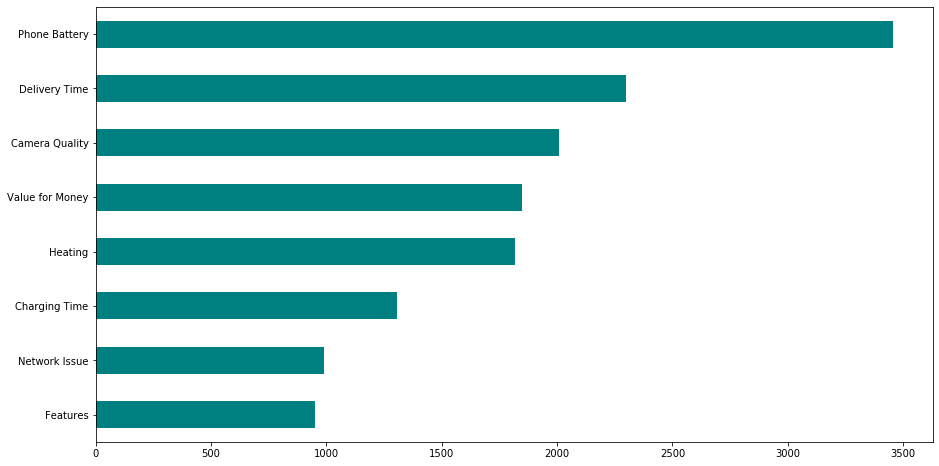

In [34]:
data['dominant_topic'].value_counts().sort_values().plot(kind='barh', figsize=(15,8), color='teal')
plt.show()

#### Understanding the sentiments over each topic for the corpus data

In [35]:
data_topic_sentiment_df = pd.DataFrame(data.groupby(by=['dominant_topic', 'sentiment']).size())

In [36]:
data_topic_sentiment_df = data_topic_sentiment_df.reset_index().rename(columns = {0: 'count'})
data_topic_sentiment_df

,dominant_topic,sentiment,count
0,Camera Quality,0,1116
1,Camera Quality,1,892
2,Charging Time,0,810
3,Charging Time,1,497
4,Delivery Time,0,1218
5,Delivery Time,1,1080
6,Features,0,494
7,Features,1,457
8,Heating,0,1029
9,Heating,1,789


#### Negetive sentiment distribution for the corpus

In [37]:
data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 0]

,dominant_topic,sentiment,count
0,Camera Quality,0,1116
2,Charging Time,0,810
4,Delivery Time,0,1218
6,Features,0,494
8,Heating,0,1029
10,Network Issue,0,708
12,Phone Battery,0,1760
14,Value for Money,0,577


#### Positive sentiment distribution for the corpus

In [38]:
data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 1]

,dominant_topic,sentiment,count
1,Camera Quality,1,892
3,Charging Time,1,497
5,Delivery Time,1,1080
7,Features,1,457
9,Heating,1,789
11,Network Issue,1,280
13,Phone Battery,1,1695
15,Value for Money,1,1273


#### Visualising the topic wise sentiment distribution for the corpus

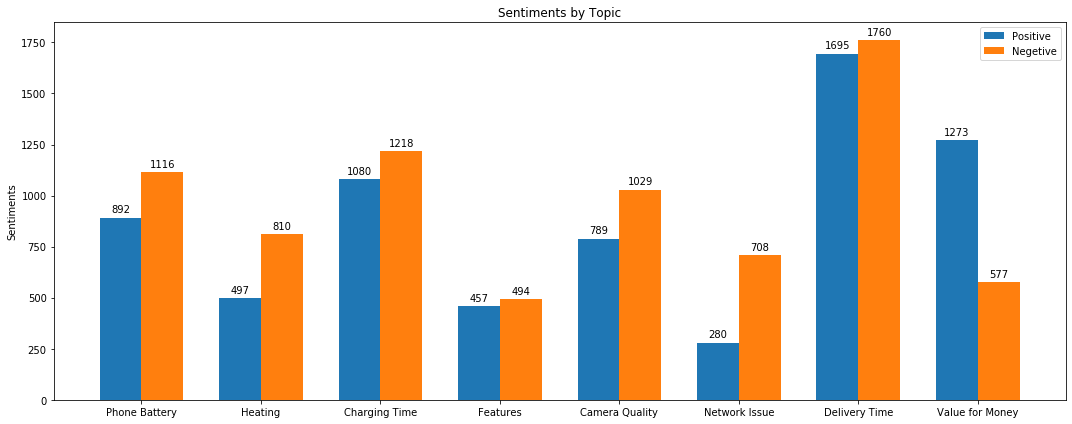

In [39]:
labels = topic_names.values()
positive_sentiments = data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 1]['count']
negetive_sentiments = data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 0]['count']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width/2, positive_sentiments, width, label='Positive')
rects2 = ax.bar(x + width/2, negetive_sentiments, width, label='Negetive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiments')
ax.set_title('Sentiments by Topic')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()